### q1

In [1]:
import numpy as np
from scipy import ndimage


def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g


def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = cv2.filter2D(src=img, ddepth=-1, kernel=Kx)
    Iy = cv2.filter2D(src=img, ddepth=-1, kernel=Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return (G.astype(np.uint8), theta)


def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z



def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)



def hysteresis(img, weak, strong=255):
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img.astype(np.uint8)

In [12]:
import os
import cv2
import matplotlib.pyplot as plt
# Folder path containing the PNG files
in_folder_path = "images/"
out_folder_path="output/"
# Iterate over files in the folder
for file_name in os.listdir(in_folder_path):
    # Check if the file has a .png extension
    if file_name.endswith(".png") or file_name.endswith(".jpg"):
        # Construct the full file path
        file_path = os.path.join(in_folder_path, file_name)
        
        # Read the image using OpenCV
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        
        gaussian_filter=gaussian_kernel(5, sigma=1.4)
        smoothed_img=cv2.filter2D(src=img, ddepth=-1, kernel=gaussian_filter)
        G, theta=sobel_filters(smoothed_img)
        z=non_max_suppression(G, theta)
        res, weak, strong=threshold(z, lowThresholdRatio=0.05, highThresholdRatio=0.09)
        finall_img=hysteresis(res, weak, strong=255)

        output_path = os.path.join(out_folder_path, file_name)
        cv2.imwrite(output_path, finall_img)

### q2

In [15]:
import cv2
import numpy as np

def calculate_pfa(edges, ground_truth):
    # Assuming white pixels represent edges, calculate false alarm rate (Pfa)
    false_positives = np.count_nonzero(edges * (1 - ground_truth))
    total_negatives = np.sum(1 - ground_truth)
    pfa = false_positives / total_negatives
    return pfa

def calculate_pratt_fom(snr, bandwidth, pfa):
    pratt_fom = (snr**2 * bandwidth) / pfa
    return pratt_fom

# Load the image
image = cv2.imread('images/baboon.png', 0)

# Apply Canny edge detection
edges_canny = cv2.Canny(image, threshold1=30, threshold2=100)

# Apply Sobel operator
sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
edges_sobel = np.uint8(magnitude > 100)



In [22]:
# Calculate Pratt Figure of Merit for Canny
pfa_canny = calculate_pfa(edges_canny, edges_sobel)
snr_canny = np.mean(image) / np.std(image)
bandwidth_canny = 1  # Assuming a receiver bandwidth of 1
pratt_fom_canny = calculate_pratt_fom(snr_canny, bandwidth_canny, pfa_canny)

In [23]:
# Calculate Pratt Figure of Merit for sobel

pfa_sobel = calculate_pfa(edges_sobel,edges_canny)
snr_sobel = np.mean(image) / np.std(image)
bandwidth_sobel = 1  # Assuming a receiver bandwidth of 1
pratt_fom_sobel = calculate_pratt_fom(snr_sobel, bandwidth_sobel, pfa_sobel)

In [24]:
pratt_fom_canny,pratt_fom_sobel

(25.983174076001937, 12.100373350937753)

### q3

#### previous place
#### hough (shape boundries) ----> always circle ball
#### changing colors to be unique
#### motion subtraction to remove useless objects ( like white board )

In [435]:
!ffmpeg -framerate 75 -i video/tst/frame_%d.jpg -c:v libx264 -r 75 -pix_fmt yuv420p output.mp4

^C


In [155]:
import subprocess

video_file = 'video/pingpong.mp4'
output_dir = 'video/frames/'

# command = ['ffmpeg', '-i', video_file, output_dir+'frame_%d.jpg']
# subprocess.run(command)

!ffmpeg -i video/pingpong.mp4 -vf fps=25 video/frames/frame_%d.jpg

ffmpeg version 4.2.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9.3.1 (GCC) 20200523
  configuration: --disable-static --enable-shared --enable-gpl --enable-version3 --enable-sdl2 --enable-fontconfig --enable-gnutls --enable-iconv --enable-libass --enable-libdav1d --enable-libbluray --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopus --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libtheora --enable-libtwolame --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libzimg --enable-lzma --enable-zlib --enable-gmp --enable-libvidstab --enable-libvorbis --enable-libvo-amrwbenc --enable-libmysofa --enable-libspeex --enable-libxvid --enable-libaom --enable-libmfx --enable-amf --enable-ffnvcodec --enable-cuvid --enable-d3d11va --enable-nvenc --enable-nvdec --enable-dxva2 --enable-avisynth --enable-libopenmpt
  libavutil 

In [1]:
import cv2

In [2]:
import matplotlib.pyplot as plt

In [172]:
img=cv2.imread('video/frames/frame_36.jpg',cv2.IMREAD_GRAYSCALE)



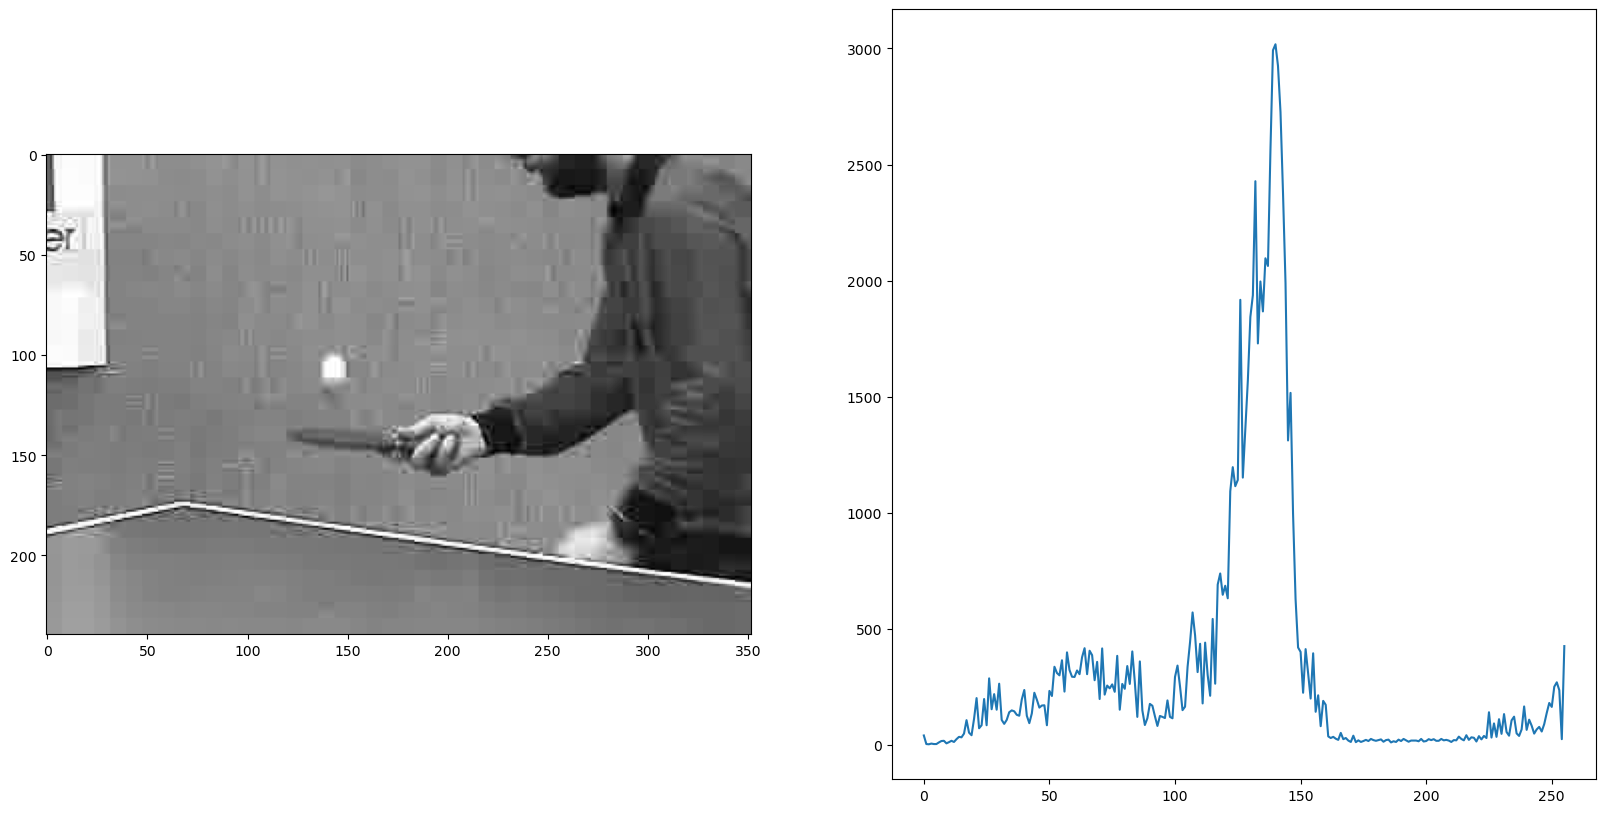

In [173]:
hist = cv2.calcHist([img], [0], None, [256], [0, 256])
from matplotlib.patches import Rectangle
fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(img,cmap='gray')
ax[1].plot(hist)
# plt.xlim([0, 256])
plt.show()

Text(0.5, 1.0, 'modified')

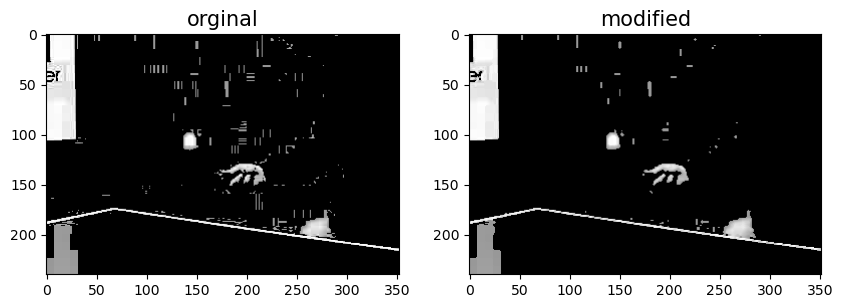

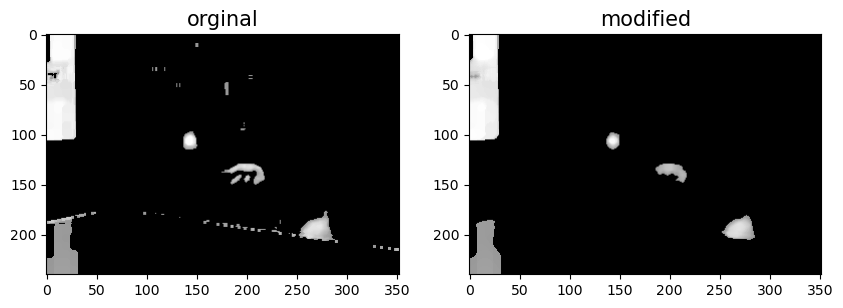

In [176]:
from matplotlib.patches import Rectangle
fig, ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(img*(img>150),cmap='gray')
# ax[0].add_patch(Rectangle((130, 50), 30, 30, edgecolor='r', facecolor='none'));
ax[0].set_title('orginal',fontsize=15)
#Showing Patch
# patch = img[50:80, 130:160]
ax[1].imshow(cv2.medianBlur(img*(img>150),3),cmap='gray')
ax[1].set_title('modified',fontsize=15)

fig, ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(cv2.medianBlur(img*(img>150),5),cmap='gray')
# ax[0].add_patch(Rectangle((130, 50), 30, 30, edgecolor='r', facecolor='none'));
ax[0].set_title('orginal',fontsize=15)
#Showing Patch
# patch = img[50:80, 130:160]
ax[1].imshow(cv2.medianBlur(img*(img>150),11),cmap='gray')
ax[1].set_title('modified',fontsize=15)


# ax[2].imshow(cv2.medianBlur(img,5),cmap='gray')
# ax[2].set_title('modified',fontsize=15)
# plt.show()

Text(0.5, 1.0, 'modified')

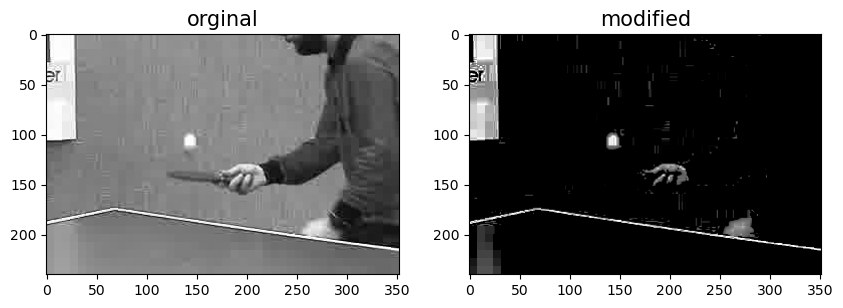

In [177]:
fig, ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(img,cmap='gray')
# ax[0].add_patch(Rectangle((130, 50), 30, 30, edgecolor='r', facecolor='none'));
ax[0].set_title('orginal',fontsize=15)
#Showing Patch
# patch = img[50:80, 130:160]
ax[1].imshow(cv2.cvtColor(cv2.equalizeHist(img*(img>150)), cv2.COLOR_GRAY2BGR),cmap='gray')
ax[1].set_title('modified',fontsize=15)



In [187]:
min_area

300

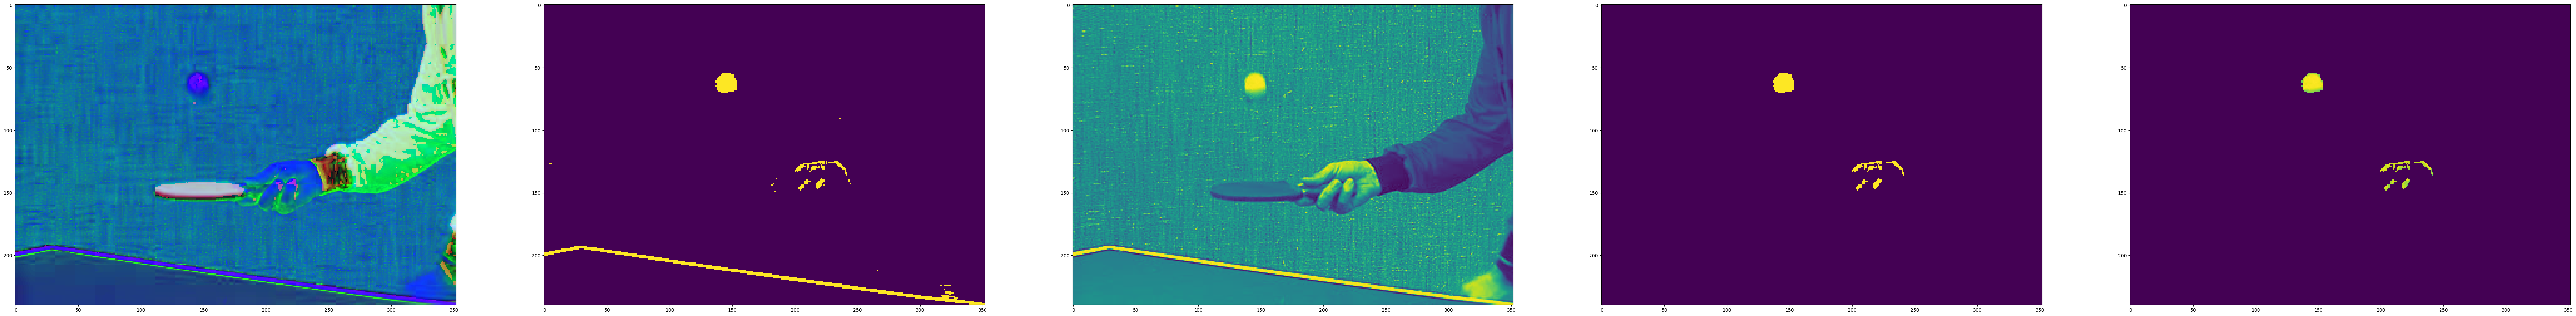

In [2]:
img=cv2.imread('video/frames/frame_1.jpg')

# Apply color segmentation
hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
sensitivty=50
lower_color = np.array([0,0,255-sensitivty])
upper_color = np.array([255,sensitivty,255])
mask = cv2.inRange(hsv_img, lower_color, upper_color)


# Apply preprocessing operations if necessary
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#         img_processed = cv2.medianBlur(img_gray * (mask > 0), 5)


num_labels,filtered_mask = filter_small_objects(mask, 300)

img_processed = img_gray * (filtered_mask >0)   

fig, ax = plt.subplots(1,5,figsize=(100,100))
ax[0].imshow(hsv_img)
ax[1].imshow(mask)
ax[2].imshow(img_gray)
ax[3].imshow(filtered_mask)
ax[4].imshow(img_processed)

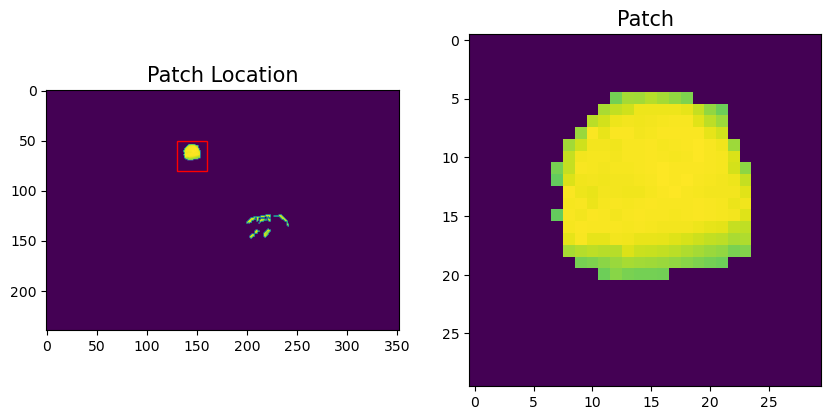

In [3]:
from matplotlib.patches import Rectangle
fig, ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(img_processed)
ax[0].add_patch(Rectangle((130, 50), 30, 30, edgecolor='r', facecolor='none'));
ax[0].set_title('Patch Location',fontsize=15)
#Showing Patch
patch = img_processed[50:80, 130:160]
ax[1].imshow(patch)
ax[1].set_title('Patch',fontsize=15)
plt.show()

In [459]:
# import os
# import cv2
# import matplotlib.pyplot as plt
# import numpy as np
# from skimage.feature import match_template, peak_local_max


# # Define the input and output folder paths
# in_folder_path = "video/frames"
# out_folder_path = "video/tst"
# patch_width, patch_height = patch.shape
# # Create the output folder if it doesn't exist
# # os.makedirs(out_folder_path, exist_ok=True)

# # Initialize the variable to store the last ROI coordinates
# last_roi = None
# i=0
# x_min= None
# def last_4chars(x):
# #     print(x[6:-4])
#     return(int(x[6:-4]))

# for file_name in sorted(os.listdir(in_folder_path), key = last_4chars):
#     # Check if the file has a .png extension
#     i+=1
#     if file_name.endswith(f"{i}.jpg"):
#         # Construct the full file path
#         file_path = os.path.join(in_folder_path, file_name)

#         # Read the image using OpenCV
#         img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
#         img1=img
#         # Apply preprocessing operations if necessary
#         img = cv2.medianBlur(img * (img > 150), 5)
        

#         # Perform template matching in the search area defined by the last ROI
#         if last_roi is not None:
#             x_min = max(0, last_roi[0] - 2*patch_height)
#             x_max = min(img.shape[0], last_roi[0] + 2*patch_height)
#             y_min = max(0, last_roi[1] - 2*patch_width)
#             y_max = min(img.shape[1], last_roi[1] + 2*patch_width)
#             search_area = img[x_min:x_max, y_min:y_max]
#             detected = match_template(search_area, patch)

#             # Find the coordinates of the detected region in the search area
#             for x, y in peak_local_max(detected, threshold_abs=0.7):
#                 roi_x = x_min + x
#                 roi_y = y_min + y
#                 last_roi = (roi_x, roi_y, patch_height, patch_width)
#                 break  # Only consider the first detected region
                
#             if not (peak_local_max(detected, threshold_abs=0.7)).any():
#                 last_roi = None
#         else:
#             # Perform template matching on the entire image if last ROI is not available
#             detected = match_template(img, patch)

#             # Find the coordinates of the detected region in the entire image
#             for x, y in peak_local_max(detected, threshold_abs=0.7):
#                 last_roi = (x, y, patch_height, patch_width)
#                 break  # Only consider the first detected region
    
#         # Save the processed image with the detected region marked
#         fig, ax = plt.subplots(1, 2, figsize=(10, 10))
#         ax[0].imshow(img, cmap='gray')
#         ax[1].imshow(img1, cmap='gray')
#         if (x_min is not None) & (last_roi is not None):
#             rect = plt.Rectangle((y_min, x_min), y_max - y_min, x_max - x_min,
#                                  color='g', lw=5, fc='none')
#             ax[0].add_patch(rect)

#             rect = plt.Rectangle((y_min, x_min), y_max - y_min, x_max - x_min,
#                                  color='g', lw=5, fc='none')
#             ax[1].add_patch(rect)
            
#         if last_roi is not None:
#             rect = plt.Rectangle((last_roi[1], last_roi[0]), patch_width, patch_height,
#                              color='r', lw=2, fc='none')
#             ax[0].add_patch(rect)

#             rect = plt.Rectangle((last_roi[1], last_roi[0]), patch_width, patch_height,
#                              color='r', lw=2, fc='none')
#             ax[1].add_patch(rect)   
            
#         output_path = os.path.join(out_folder_path, file_name)
#         plt.savefig(output_path)
#         plt.close()
# #         plt.show()

In [105]:
def filter_small_objects(image, min_area ,min_area2):
    # Find connected components in the image
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(image, connectivity=8)

    # Filter small objects based on their area
    filtered_labels = np.zeros_like(labels)
    for label in range(1, num_labels):
        area = stats[label, cv2.CC_STAT_AREA]
        if (area <= min_area) & (area >= min_area2 ):
            filtered_labels[labels == label] = 255

    return num_labels,filtered_labels.astype(np.uint8)


def filter_round_contours(contours, threshold):
    filtered_contours = []
  
    for contour in contours:
        perimeter = cv2.arcLength(contour, True)
        area = cv2.contourArea(contour)
      
        if perimeter > 0:
            circularity = 4 * np.pi * (area / (perimeter ** 2))
          
            if circularity >= threshold:
                filtered_contours.append(contour)

    return filtered_contours


import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import match_template, peak_local_max


# Define the input and output folder paths
in_folder_path = "video/frames"
out_folder_path = "video/tst"
patch_width, patch_height = patch.shape
# Create the output folder if it doesn't exist
# os.makedirs(out_folder_path, exist_ok=True)
min_area = 300
min_area2=10
# Initialize the variable to store the last ROI coordinates
last_roi = None
i=0
x_min= None
sensitivty=50
kernel = np.ones((3, 3), np.uint8)

def last_4chars(x):
#     print(x[6:-4])
    return(int(x[6:-4]))

for file_name in sorted(os.listdir(in_folder_path), key = last_4chars):
    # Check if the file has a .png extension
#     if i==9:
#         print('i==62')
#         break
    
    i+=1
    if i==75:
        last_roi = None
        sensitivty=45
        min_area=20
    if file_name.endswith(f"{i}.jpg"):
        # Construct the full file path
        file_path = os.path.join(in_folder_path, file_name)

        # Read the image using OpenCV
        img = cv2.imread(file_path)
        
        # Apply color segmentation
        hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        
        lower_color = np.array([0,0,255-sensitivty])
        upper_color = np.array([255,sensitivty,255])
        mask = cv2.inRange(hsv_img, lower_color, upper_color)

        # Apply preprocessing operations if necessary
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        
        num_labels,filtered_mask = filter_small_objects(mask, min_area,min_area2)
        img_processed = img_gray * (filtered_mask >0)
        
        if min_area>200:
            img_processed = cv2.erode(img_processed, kernel, iterations=1)
            
        img_processed = cv2.dilate(img_processed, kernel, iterations=1)
        # Perform template matching in the search area defined by the last ROI

        
        if last_roi is not None:
            x_min = max(0, last_roi[0] - 2*patch_height)
            x_max = min(img.shape[0], last_roi[0] + 3*patch_height)
            y_min = max(0, last_roi[1] - 2*patch_width)
            y_max = min(img.shape[1], last_roi[1] + 2*patch_width)
            search_area = img_processed[x_min:x_max, y_min:y_max]
            
            detected = match_template(search_area, patch)
            
            

            # Find the coordinates of the detected region in the search area
            for x, y in peak_local_max(detected, threshold_abs=0.3):
                roi_x = x_min + x
                roi_y = y_min + y
                last_roi = (roi_x, roi_y, patch_height, patch_width)
                print(i)
                break  # Only consider the first detected region
    
            if not (peak_local_max(detected, threshold_abs=0.3)).any():
            
                img_processed = cv2.dilate(img_processed, kernel, iterations=3)    
                search_area = img_processed[x_min:x_max, y_min:y_max]
                
                detected = match_template(search_area, patch)
                print('scaling')


                # Find the coordinates of the detected region in the search area
                for x, y in peak_local_max(detected, threshold_abs=0.7):
                    roi_x = x_min + x
                    roi_y = y_min + y
                    last_roi = (roi_x, roi_y, patch_height, patch_width)
                    print(i)
                    break  # Only consider the first detected region
                if not (peak_local_max(detected, threshold_abs=0.7)).any():
                    last_roi = None
                    if num_labels >0:
                        min_area = 50
                        min_area2=10
                        print(f'min_area changed at frame {i}')
                    
                
        else:
            # Perform template matching on the entire image if last ROI is not available
            detected = match_template(img_processed, patch)

            # Find the coordinates of the detected region in the entire image
            for x, y in peak_local_max(detected, threshold_abs=0.5):
                last_roi = (x, y, patch_height, patch_width)
                break  # Only consider the first detected region
                
                
        # Find contours in the binary image of the OOI
        contours, _ = cv2.findContours(filtered_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Draw contours on the original image
        img_contour = img.copy()
        cv2.drawContours(img_contour, contours, -1, (0, 255, 0), 2)
        
        # Save the processed image with the detected region marked
        fig, ax = plt.subplots(1, 2, figsize=(20, 20))
        ax[0].imshow(img_processed)
        ax[1].imshow(cv2.cvtColor(img_contour, cv2.COLOR_BGR2RGB))

        if (x_min is not None) & (last_roi is not None):
            rect = plt.Rectangle((y_min, x_min), y_max , x_max ,
                                 color='g', lw=5, fc='none')
            ax[0].add_patch(rect)

            rect = plt.Rectangle((y_min, x_min), y_max - y_min, x_max - x_min,
                                 color='g', lw=5, fc='none')
            ax[1].add_patch(rect)
            
        if last_roi is not None:
            rect = plt.Rectangle((last_roi[1], last_roi[0]), patch_width, patch_height,
                             color='r', lw=2, fc='none')
            ax[0].add_patch(rect)

            rect = plt.Rectangle((last_roi[1], last_roi[0]), patch_width, patch_height,
                             color='r', lw=2, fc='none')
            ax[1].add_patch(rect)   
            
        output_path = os.path.join(out_folder_path, file_name)
        plt.savefig(output_path)
        plt.close()


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


KeyboardInterrupt: 

In [474]:
i

60

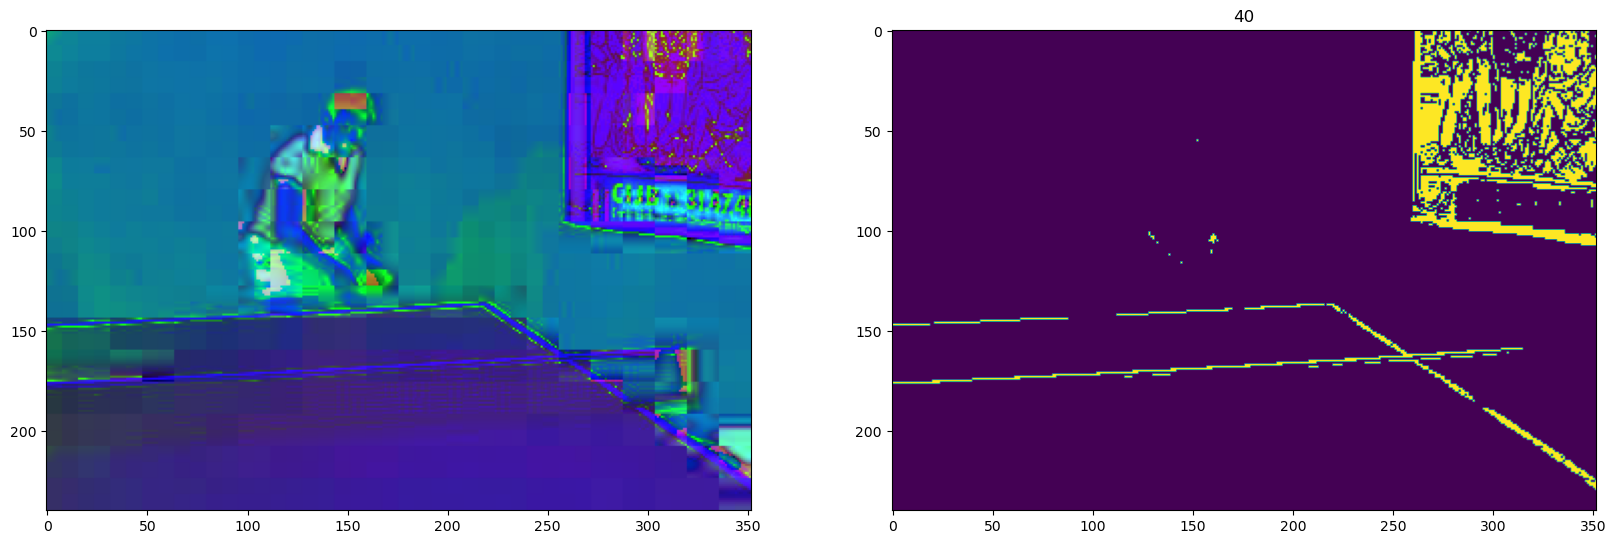

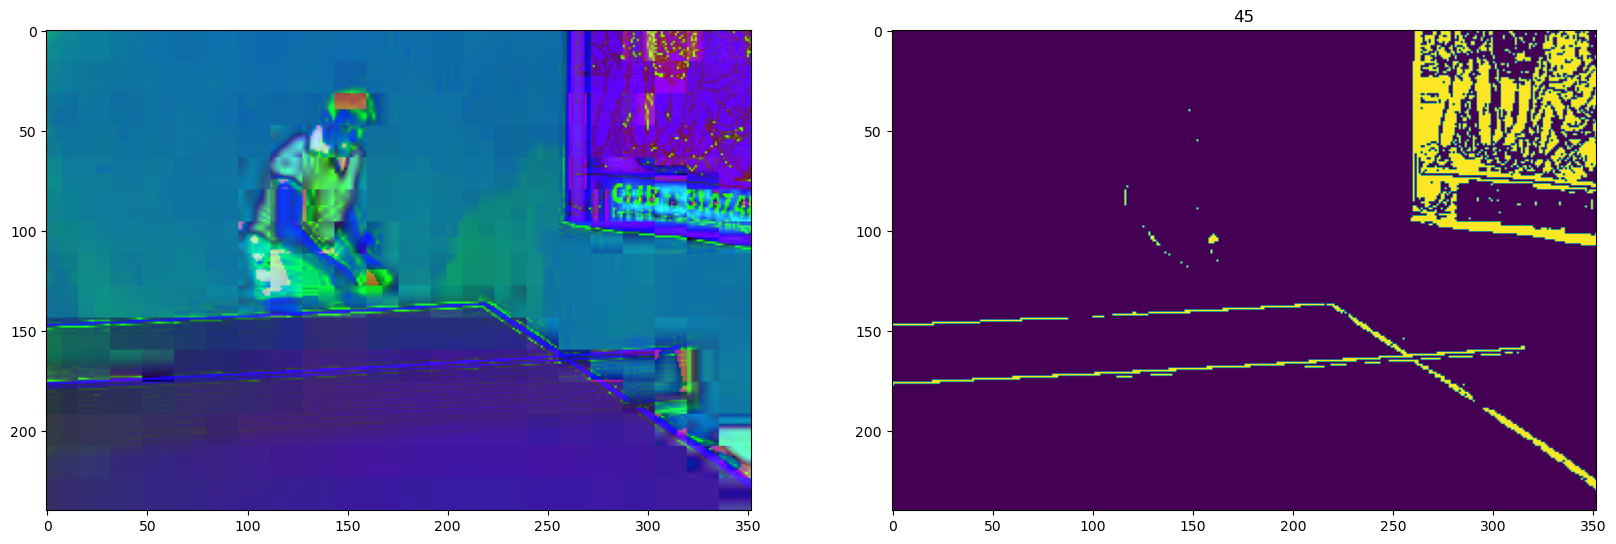

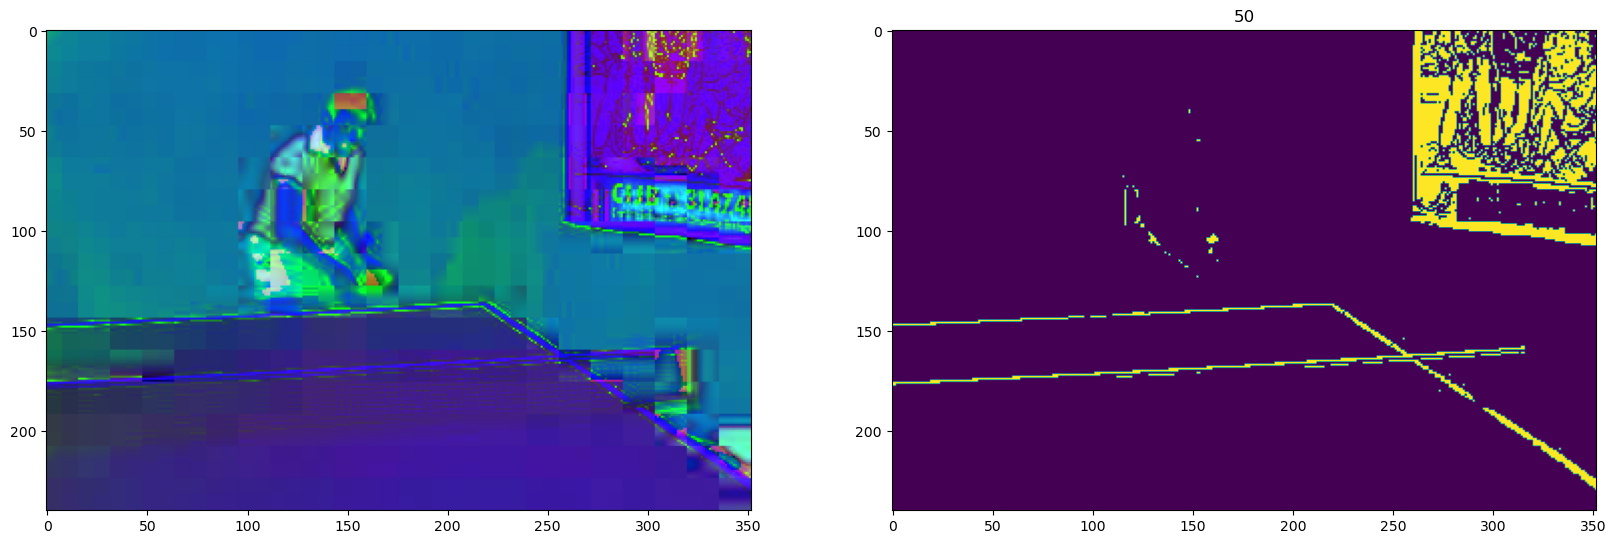

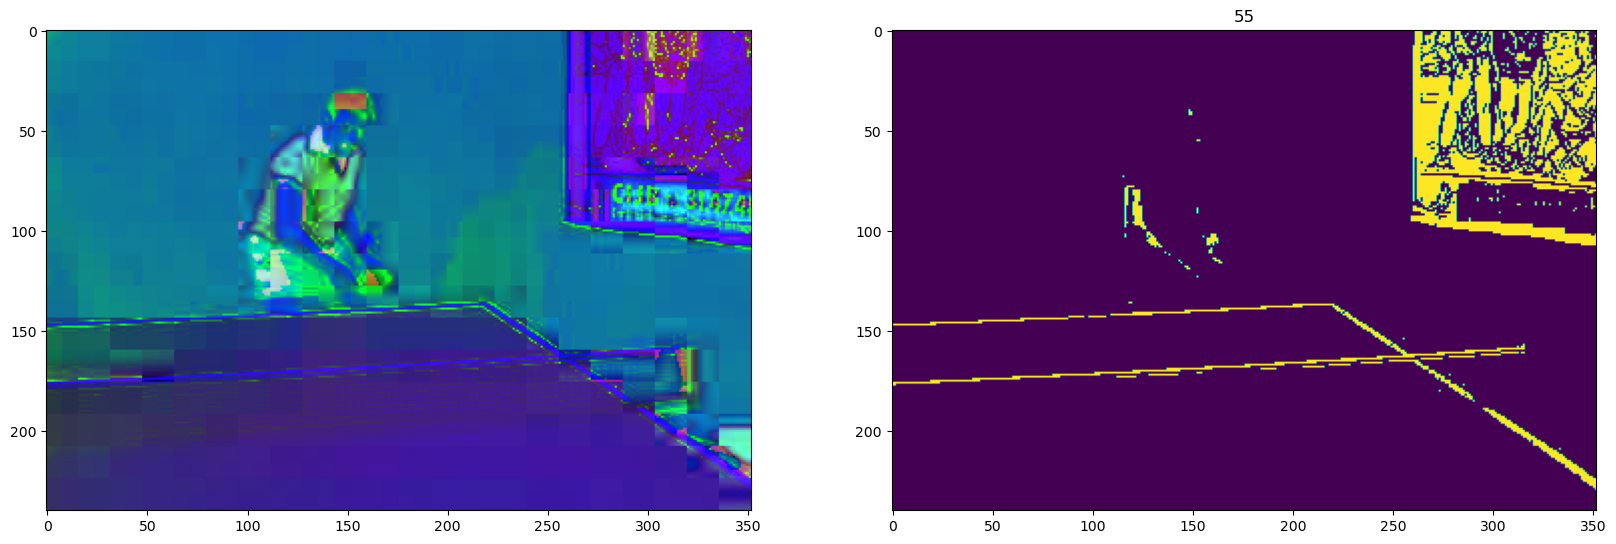

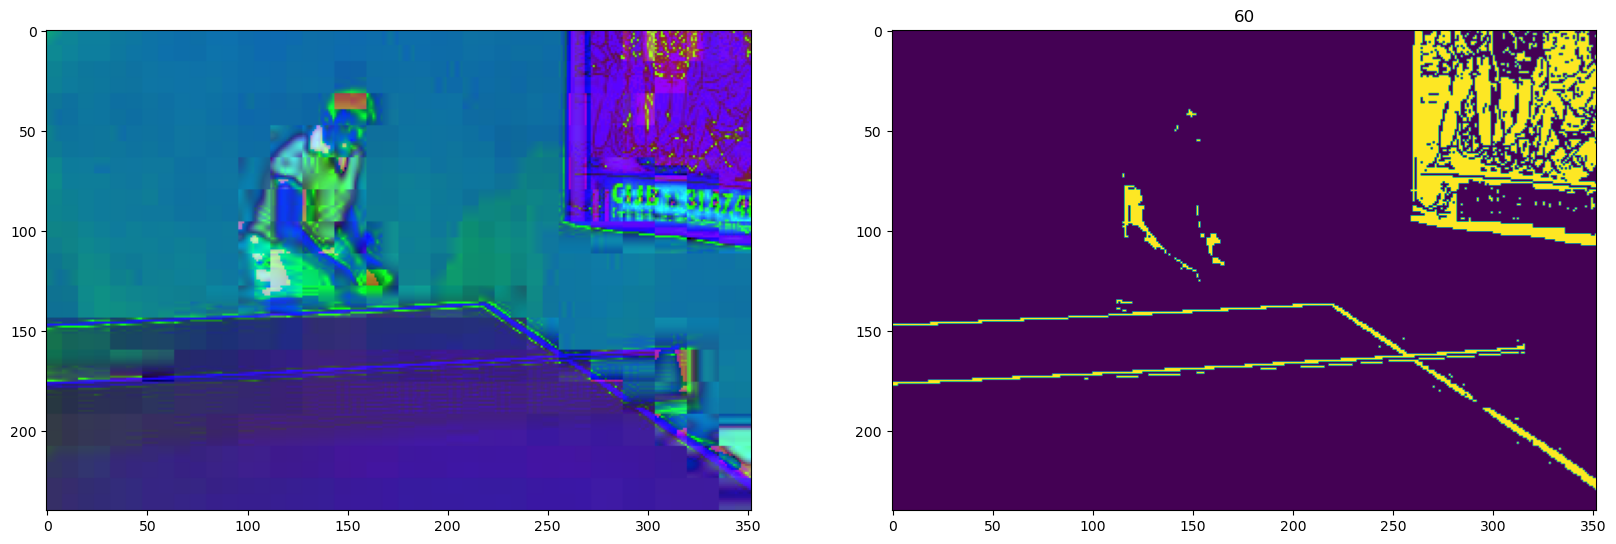

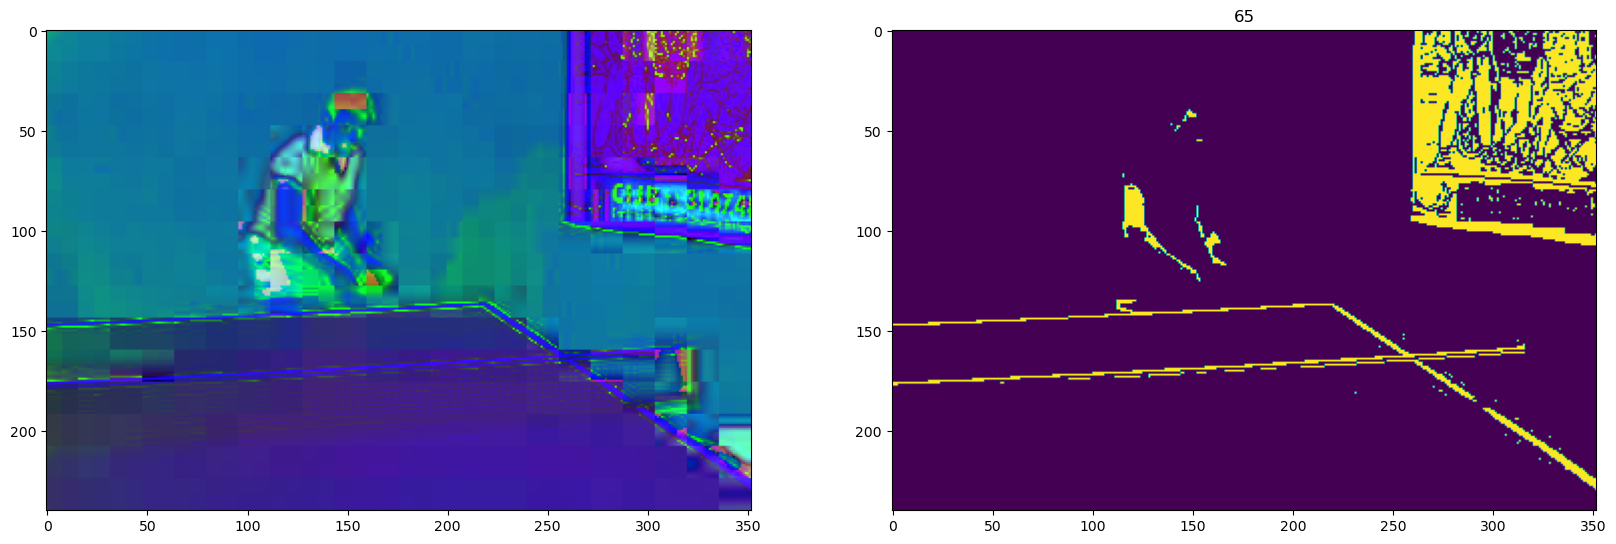

In [91]:
img=cv2.imread('video/frames/frame_75.jpg')





hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)


for i in np.arange(40,70,5):
    
    lower_color = np.array([0,0,255-i])
    upper_color = np.array([255,i,255])

    fig, ax = plt.subplots(1, 2, figsize=(20, 20))
    ax[0].imshow(hsv_img)

    mask = cv2.inRange(hsv_img, lower_color, upper_color)
    ax[1].imshow(mask)
    plt.title(i)
    plt.show()
    

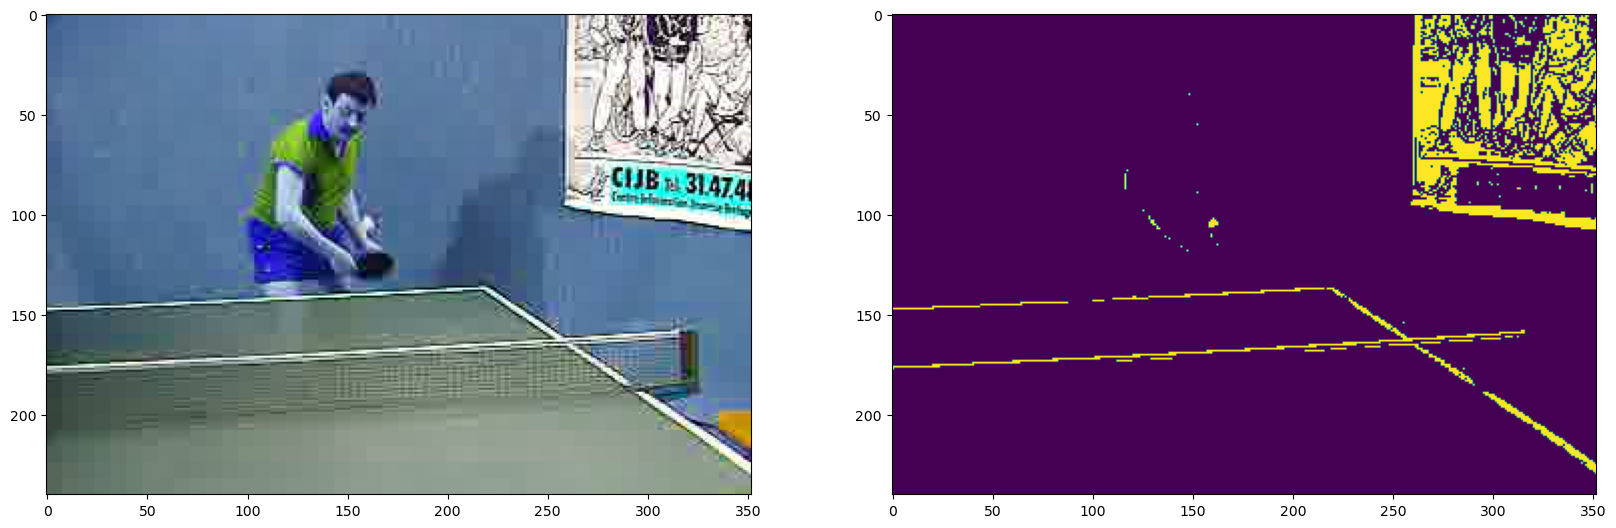

In [97]:

# for d in range(75,120):


img=cv2.imread('video/frames/frame_75.jpg')

hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)


i=45    
lower_color = np.array([0,0,255-i])
upper_color = np.array([255,i,255])

fig, ax = plt.subplots(1, 2, figsize=(20, 20))
ax[0].imshow(img, cmap='gray')

mask = cv2.inRange(hsv_img, lower_color, upper_color)
ax[1].imshow(mask)

plt.show()
    


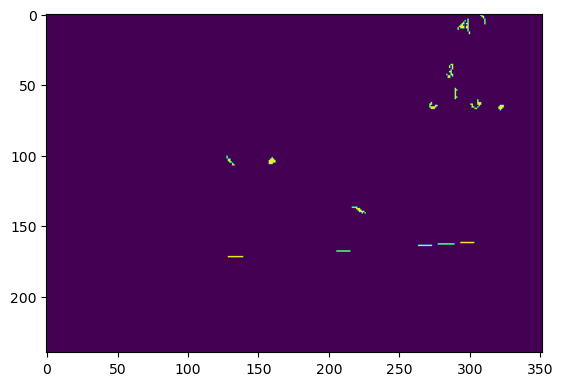

In [100]:



num_labels,filtered_mask =filter_small_objects(mask, 20,10)
plt.imshow(filtered_mask)

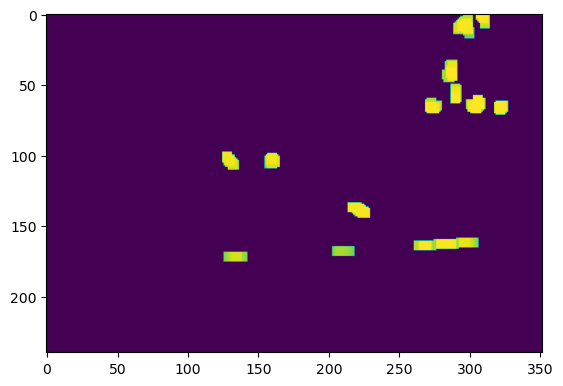

In [94]:
img=cv2.imread('video/frames/frame_75.jpg')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#         img_processed = cv2.medianBlur(img_gray * (mask > 0), 5)
#         img_processed = cv2.medianBlur(img_gray * (filtered_mask), 5)

out2=cv2.dilate(img_gray * (filtered_mask>0), kernel, iterations=1)
out2 = cv2.dilate(out2, kernel, iterations=2)
plt.imshow(out2)

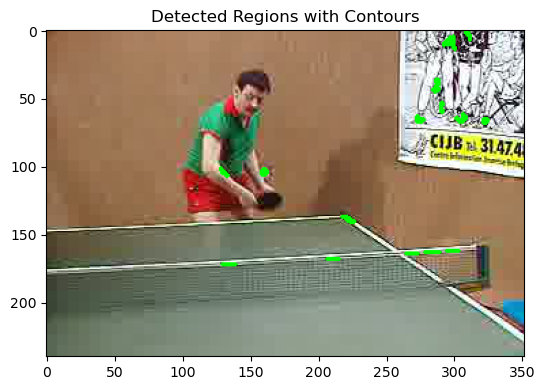

In [95]:
# Find contours in the binary image of the OOI
contours, _ = cv2.findContours(filtered_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the original image
img_contour = img.copy()
cv2.drawContours(img_contour, contours, -1, (0, 255, 0), 2)

# Visualize the processed image with detected regions and contours
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
axes.imshow(cv2.cvtColor(img_contour, cv2.COLOR_BGR2RGB))
axes.set_title('Detected Regions with Contours')

plt.tight_layout()
plt.show()



In [47]:
contour

array([[[ 98, 202]],

       [[ 98, 208]],

       [[103, 208]],

       [[104, 209]],

       [[108, 209]],

       [[109, 210]],

       [[119, 210]],

       [[119, 204]],

       [[115, 204]],

       [[114, 203]],

       [[110, 203]],

       [[109, 202]]], dtype=int32)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (7,) + inhomogeneous part.

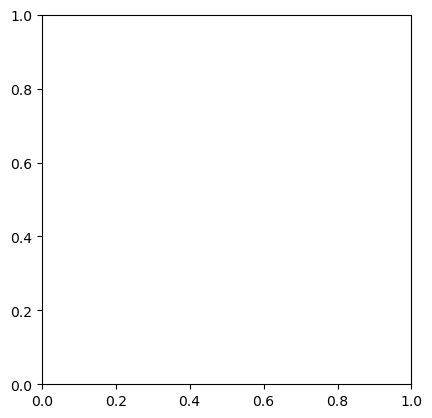

In [41]:
contours, _ = cv2.findContours(out2.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

plt.imshow(contours)

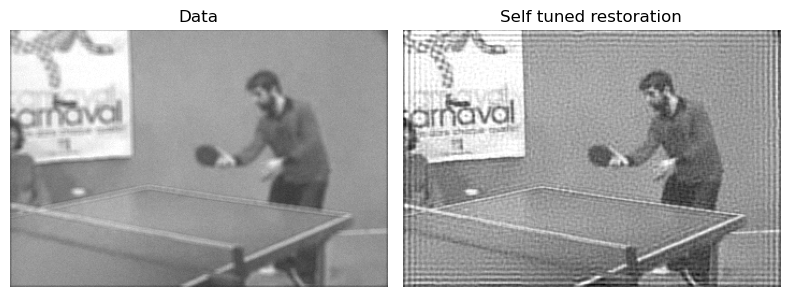

In [262]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import color, data, restoration

rng = np.random.default_rng()

image = color.rgb2gray(cv2.imread('video/frames/frame_70.jpg'))
# img=img.astype(np.float64)
# img *= (255.0/img.max())
# img *= 1/255

astro=img
from scipy.signal import convolve2d as conv2
psf = np.ones((5, 5)) / 25
astro = conv2(astro, psf, 'same')
astro += 0.1 * astro.std() * rng.standard_normal(astro.shape)

deconvolved, _ = restoration.unsupervised_wiener(astro, psf)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 5),
                       sharex=True, sharey=True)

plt.gray()

ax[0].imshow(astro, vmin=deconvolved.min(), vmax=deconvolved.max())
ax[0].axis('off')
ax[0].set_title('Data')

ax[1].imshow(deconvolved)
ax[1].axis('off')
ax[1].set_title('Self tuned restoration')

fig.tight_layout()

plt.show()

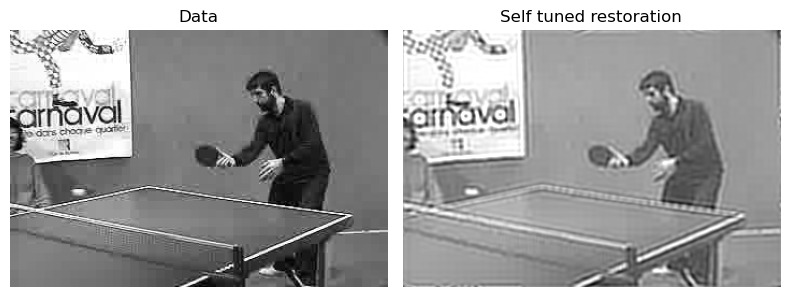

In [260]:
from scipy.signal import convolve2d
from skimage import color, data, restoration

def wiener_deblur(image, kernel_size, snr):
    # Create a uniform kernel
    kernel = np.ones((kernel_size, kernel_size)) / kernel_size**2

    # Apply the Wiener Filter
    deblurred = restoration.wiener(image, kernel, snr)

    return deblurred


# Load the image
image = color.rgb2gray(cv2.imread('video/frames/frame_70.jpg'))

# Set the kernel size and SNR
kernel_size = 5
snr = 0.1

# Deblur the image using the Wiener Filter
deblurred = wiener_deblur(image, kernel_size, snr)


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))


ax[0].imshow(image)
ax[0].axis('off')
ax[0].set_title('Data')

ax[1].imshow(deblurred)
ax[1].axis('off')
ax[1].set_title('Self tuned restoration')

fig.tight_layout()

plt.show()

In [256]:
image

array([[5.83434902e-01, 4.14859216e-01, 2.44058431e-01, ...,
        4.75007843e-01, 4.58213333e-01, 4.69121961e-01],
       [6.75588235e-01, 5.56006667e-01, 4.49052941e-01, ...,
        4.68548627e-01, 4.56501176e-01, 4.55958431e-01],
       [7.66334902e-01, 7.00524314e-01, 6.49276078e-01, ...,
        4.76406667e-01, 4.62104314e-01, 4.53978431e-01],
       ...,
       [6.81696471e-01, 6.81979216e-01, 6.71889020e-01, ...,
        0.00000000e+00, 2.82745098e-04, 0.00000000e+00],
       [6.74694510e-01, 6.68532941e-01, 6.64030196e-01, ...,
        2.82745098e-04, 3.92156863e-03, 0.00000000e+00],
       [6.70482353e-01, 6.63189804e-01, 6.52838824e-01, ...,
        0.00000000e+00, 3.92156863e-03, 0.00000000e+00]])

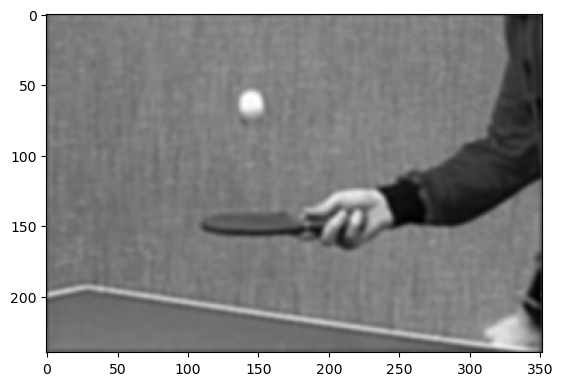

In [220]:
import numpy as np
#import matplotlib.pyplot as plt
# from scipy.misc import imfilter, imread
from skimage import color, data, restoration
from scipy.signal import convolve2d as conv2

image = cv2.imread('video/frames/frame_1.jpg', cv2.IMREAD_GRAYSCALE)
#plt.imshow(arr, cmap='gray')
#plt.show()
#blurred_arr = imfilter(arr, "blur")
psf = np.ones((3, 3)) / 9
image = conv2(image, psf, 'same')
image += 0.1 * image.std() * np.random.standard_normal(image.shape)

deconvolved = restoration.wiener(image, psf, 1, clip=False)
#print deconvolved
plt.imshow(deconvolved, cmap='gray')
plt.show()

In [244]:
img = cv2.imread('video/frames/frame_18.jpg', cv2.IMREAD_GRAYSCALE)
img=img.astype(np.float64)
img 
img

array([[0.55686275, 0.55686275, 0.55686275, ..., 0.23137255, 0.23137255,
        0.23137255],
       [0.54901961, 0.54901961, 0.54901961, ..., 0.23137255, 0.23137255,
        0.23137255],
       [0.54117647, 0.54117647, 0.54117647, ..., 0.23137255, 0.23137255,
        0.23137255],
       ...,
       [0.49019608, 0.49019608, 0.49019608, ..., 0.3372549 , 0.17647059,
        0.08235294],
       [0.49019608, 0.49019608, 0.49019608, ..., 0.9372549 , 0.90980392,
        0.89019608],
       [0.49019608, 0.49019608, 0.49019608, ..., 1.        , 1.        ,
        1.        ]])

In [ ]:
import cv2
import sys
import numpy as np

def nothing(x):
    pass

# Load in image
image = cv2.imread('video/frames/frame_1.jpg')

# Create a window
cv2.namedWindow('image')

# create trackbars for color change
cv2.createTrackbar('HMin','image',0,179,nothing) # Hue is from 0-179 for Opencv
cv2.createTrackbar('SMin','image',0,255,nothing)
cv2.createTrackbar('VMin','image',0,255,nothing)
cv2.createTrackbar('HMax','image',0,179,nothing)
cv2.createTrackbar('SMax','image',0,255,nothing)
cv2.createTrackbar('VMax','image',0,255,nothing)

# Set default value for MAX HSV trackbars.
cv2.setTrackbarPos('HMax', 'image', 179)
cv2.setTrackbarPos('SMax', 'image', 255)
cv2.setTrackbarPos('VMax', 'image', 255)

# Initialize to check if HSV min/max value changes
hMin = sMin = vMin = hMax = sMax = vMax = 0
phMin = psMin = pvMin = phMax = psMax = pvMax = 0

output = image
wait_time = 33

while(1):

    # get current positions of all trackbars
    hMin = cv2.getTrackbarPos('HMin','image')
    sMin = cv2.getTrackbarPos('SMin','image')
    vMin = cv2.getTrackbarPos('VMin','image')

    hMax = cv2.getTrackbarPos('HMax','image')
    sMax = cv2.getTrackbarPos('SMax','image')
    vMax = cv2.getTrackbarPos('VMax','image')

    # Set minimum and max HSV values to display
    lower = np.array([hMin, sMin, vMin])
    upper = np.array([hMax, sMax, vMax])

    # Create HSV Image and threshold into a range.
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower, upper)
    output = cv2.bitwise_and(image,image, mask= mask)

    # Print if there is a change in HSV value
    if( (phMin != hMin) | (psMin != sMin) | (pvMin != vMin) | (phMax != hMax) | (psMax != sMax) | (pvMax != vMax) ):
        print("(hMin = %d , sMin = %d, vMin = %d), (hMax = %d , sMax = %d, vMax = %d)" % (hMin , sMin , vMin, hMax, sMax , vMax))
        phMin = hMin
        psMin = sMin
        pvMin = vMin
        phMax = hMax
        psMax = sMax
        pvMax = vMax

    # Display output image
    cv2.imshow('image',output)

    # Wait longer to prevent freeze for videos.
    if cv2.waitKey(wait_time) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()